# Road Segmentation Project

### ETH Computational Intelligence Lab 2024

The project is about image segmentation, which is an important topic in Computer Vision. It has applications in autonomous driving, reconstruction and medical domain, etc. In this project, you will focus on the road segmentation problem. **Given a set of RGB aerial images, we are asked to classify each 16x16 pixel patch as either containing road (1) or not (0).**

Below you will find three relevant baselines, from classical statical methods to some more sophisticated machine learning models for solving the problem. These baselines are in no sense optimal or exhaustive, but can serve more or less as a starting point for the project.


# Data Exploration

In this project, you are provided with training set with (**only!**) 144 RGB images of resolution 400 x 400 px, and you are given two types of labels pixel-wise: 1 for road, and 0 otherwise. Notice that here, the patch labeling are not directly available, instead, you need to calculate the average of the label, that if at least 25% of pixels are labeled as road, then it would be considered as a "road patch". As for the test set, it consists of 144 images of the same resolution as the original image.

For the purpose of illustration, we apply a **fixed training/validation split**. Notice that sticking a fixed split can significantly bias the validation metric, thus you may need to consider better validation strategy, and consider using all training images for the final submission.

In [23]:
# some basic imports

import math
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from random import sample
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

In [24]:
PATCH_SIZE = 16  # pixels per side of square patches
VAL_SIZE = 10  # size of the validation set (number of images)
CUTOFF = 0.25  # minimum average brightness for a mask patch to be classified as containing road

In [25]:
ROOT_PATH = ""
test_path = "test"

In [57]:
def load_all_from_path(path):
    # loads all HxW .pngs contained in path as a 4D np.array of shape (n_images, H, W, 3)
    # images are loaded as floats with values in the interval [0., 1.]
    return np.stack([np.array(Image.open(f)) for f in sorted(glob(path + '/*.png'))]).astype(np.float32) / 255.

def show_first_n(imgs, masks, n=5):
    # visualizes the first n elements of a series of images and segmentation masks
    imgs_to_draw = min(5, len(imgs))
    fig, axs = plt.subplots(2, imgs_to_draw, figsize=(18.5, 6))
    for i in range(imgs_to_draw):
        axs[0, i].imshow(imgs[i])
        lines = cv2.HoughLinesP(imgs[i]
, rho=1, theta=np.pi / 180, threshold=128, minLineLength=600, maxLineGap=30,).squeeze()
        for x1, y1, x2, y2 in lines:
            axs[0, i].plot([x1, x2], [y1, y2], "r")
        axs[1, i].imshow(masks[i])
        axs[0, i].set_title(f'Image {i}')
        axs[1, i].set_title(f'Mask {i}')
        axs[0, i].set_axis_off()
        axs[1, i].set_axis_off()
    plt.show()

In [55]:
images = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'images'))[:, :, :, :3]
masks = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'groundtruth'))

In [ ]:
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

show_first_n(train_images, train_masks)

We have mentioned that our task can also be seen as a classification problem. Let us visualize how each image can be broken up in patches and how we can compute labels from groundtruth masks.

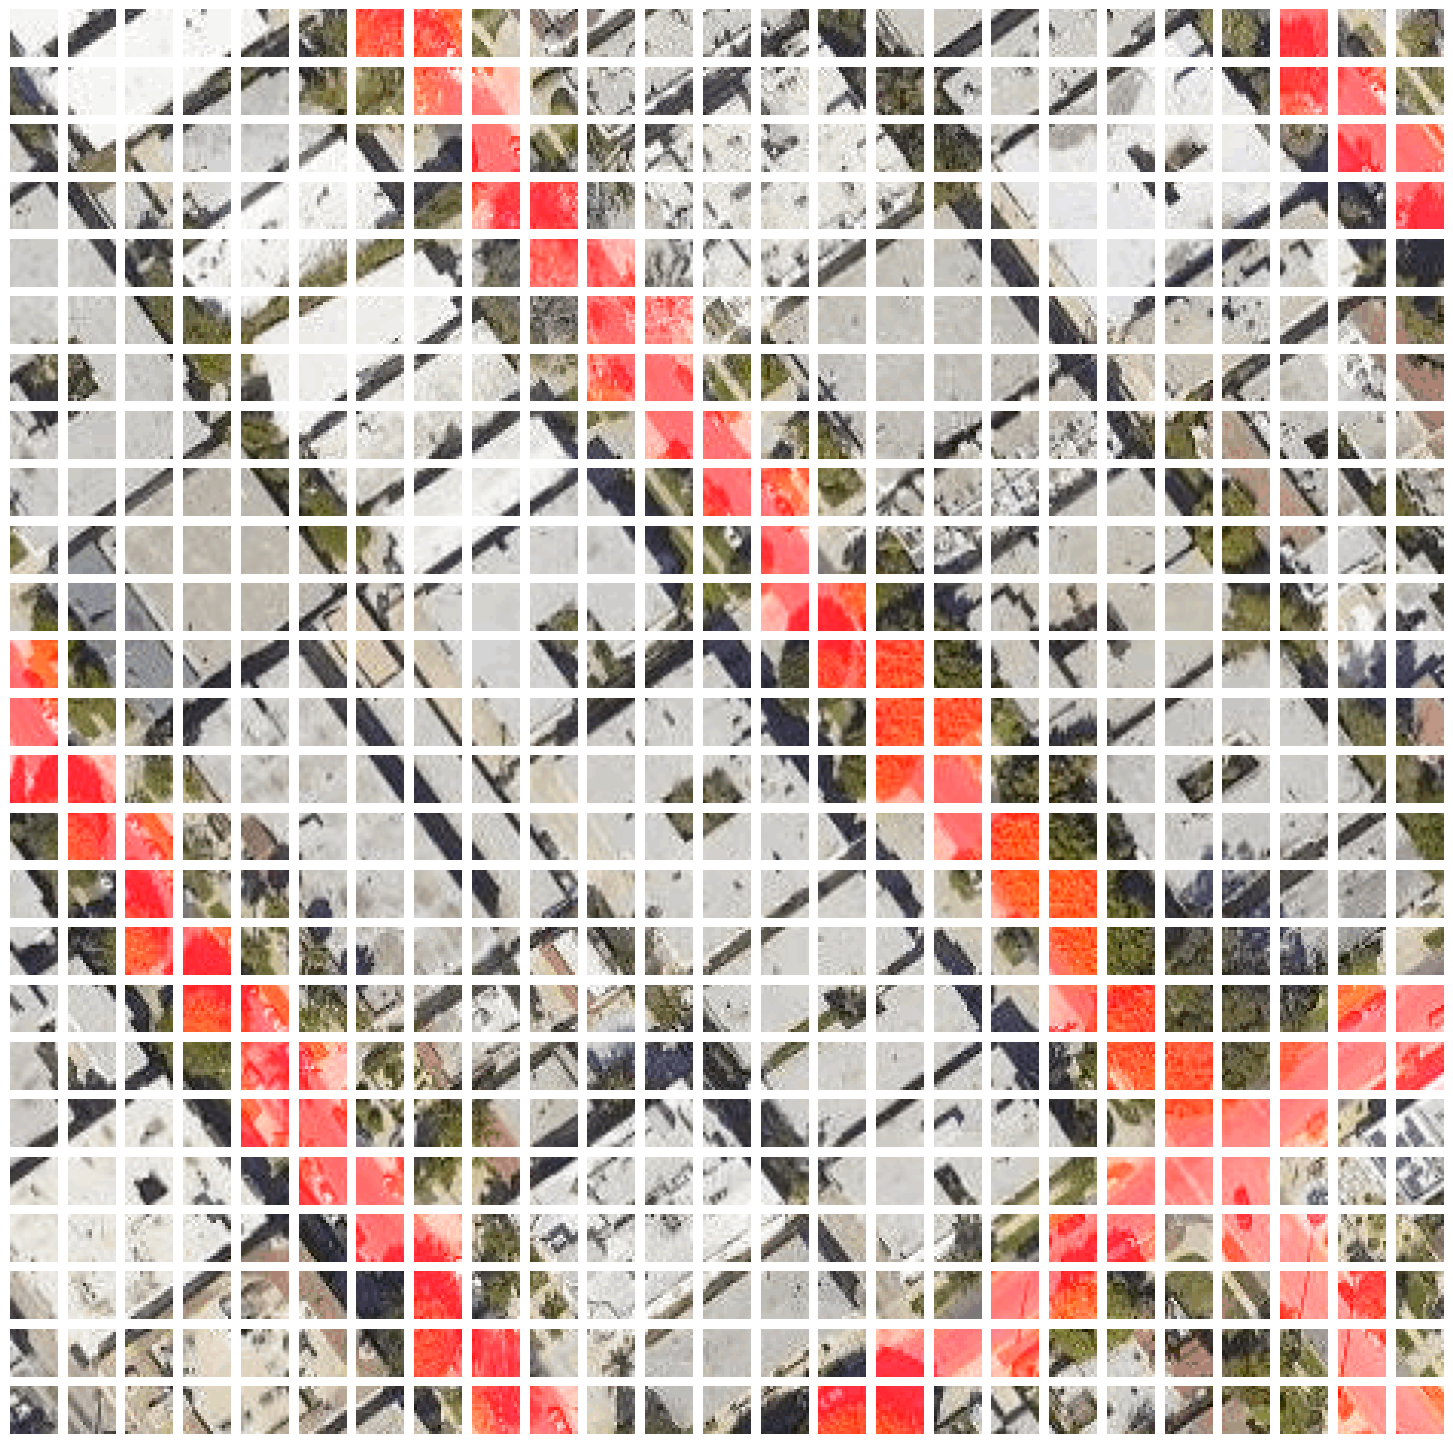

In [29]:
def image_to_patches(images, masks=None):
    # takes in a 4D np.array containing images and (optionally) a 4D np.array containing the segmentation masks
    # returns a 4D np.array with an ordered sequence of patches extracted from the image and (optionally) a np.array containing labels
    n_images = images.shape[0]  # number of images
    h, w = images.shape[1:3]  # shape of images
    assert (h % PATCH_SIZE) + (w % PATCH_SIZE) == 0  # make sure images can be patched exactly

    images = images[:,:,:,:3]

    h_patches = h // PATCH_SIZE
    w_patches = w // PATCH_SIZE

    patches = images.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    patches = np.moveaxis(patches, 2, 3)
    patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, 3)
    if masks is None:
        return patches

    masks = masks.reshape((n_images, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE, -1))
    masks = np.moveaxis(masks, 2, 3)
    labels = np.mean(masks, (-1, -2, -3)) > CUTOFF  # compute labels
    labels = labels.reshape(-1).astype(np.float32)
    return patches, labels


def show_patched_image(patches, labels, h_patches=25, w_patches=25, figsize=(18.5, 18.5)):
    # reorders a set of patches in their original 2D shape and visualizes them
    fig, axs = plt.subplots(h_patches, w_patches, figsize=figsize)
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()


# extract all patches and visualize those from the first image
train_patches, train_labels = image_to_patches(train_images, train_masks)
val_patches, val_labels = image_to_patches(val_images, val_masks)

# the first image is broken up in the first 25*25 patches
show_patched_image(train_patches[:25*25], train_labels[:25*25])




In [30]:
def create_submission(labels, test_filenames, submission_filename):
    test_path = os.path.join(ROOT_PATH, 'training', 'images')
    with open(submission_filename, 'w') as f:
        f.write('id,prediction\n')
        for fn, patch_array in zip(sorted(test_filenames), test_pred):
            img_number = int(re.search(r"\d+", fn).group(0))
            for i in range(patch_array.shape[0]):
                for j in range(patch_array.shape[1]):
                    f.write("{:03d}_{}_{},{}\n".format(img_number, j*PATCH_SIZE, i*PATCH_SIZE, int(patch_array[i, j])))

test_path = os.path.join(ROOT_PATH, 'training', 'images')
test_filenames = sorted(glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
test_patches = image_to_patches(test_images)

It appears that the classification task might be **largely unbalanced**. Let us verify it.

In [31]:
print("{0:0.2f}".format(sum(train_labels) / len(train_labels) * 100) + '% of training patches are labeled as 1.')
print("{0:0.2f}".format(sum(val_labels) / len(val_labels) * 100) + '% of validation patches are labeled as 1.')

24.49% of training patches are labeled as 1.
25.30% of validation patches are labeled as 1.


This means that a trivial classifier that always assigns the majority class (0) to each sample would already reach an accuracy of about ~75%.

In [32]:
import torch
from torch import nn
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import tqdm

def np_to_tensor(x, device):
    # allocates tensors from np.arrays
    if device == 'cpu':
        return torch.from_numpy(x).cpu()
    else:
        return torch.from_numpy(x).contiguous().pin_memory().to(device=device, non_blocking=True)


class ImageDataset(torch.utils.data.Dataset):
    # dataset class that deals with loading the data and making it available by index.

    def __init__(self, is_train, device, use_patches=True, resize_to=(400, 400)):
        self.is_train = is_train
        self.device = device
        self.use_patches = use_patches
        self.resize_to=resize_to
        self.x, self.y, self.n_samples = None, None, None
        self._load_data()

    def _load_data(self):  # not very scalable, but good enough for now
        self.x = train_images if self.is_train else val_images
        self.y = train_masks if self.is_train else val_masks
        if self.use_patches:  # split each image into patches
            self.x, self.y = image_to_patches(self.x, self.y)
        elif self.resize_to != (self.x.shape[1], self.x.shape[2]):  # resize images
            self.x = np.stack([cv2.resize(img, dsize=self.resize_to) for img in self.x], 0)
            self.y = np.stack([cv2.resize(mask, dsize=self.resize_to) for mask in self.y], 0)
        self.x = np.moveaxis(self.x, -1, 1)  # pytorch works with CHW format instead of HWC
        self.n_samples = len(self.x)

    def _preprocess(self, x, y):
        # to keep things simple we will not apply transformations to each sample,
        # but it would be a very good idea to look into preprocessing
        return x, y

    def __getitem__(self, item):
        return self._preprocess(np_to_tensor(self.x[item], self.device), np_to_tensor(self.y[[item]], self.device))

    def __len__(self):
        return self.n_samples


def show_val_samples(x, y, y_hat, segmentation=False):
    # training callback to show predictions on validation set
    imgs_to_draw = min(5, len(x))
    if x.shape[-2:] == y.shape[-2:]:  # segmentation
        fig, axs = plt.subplots(3, imgs_to_draw, figsize=(18.5, 12))
        for i in range(imgs_to_draw):
            axs[0, i].imshow(np.moveaxis(x[i], 0, -1))
            axs[1, i].imshow(np.concatenate([np.moveaxis(y_hat[i], 0, -1)] * 3, -1))
            axs[2, i].imshow(np.concatenate([np.moveaxis(y[i], 0, -1)]*3, -1))
            axs[0, i].set_title(f'Sample {i}')
            axs[1, i].set_title(f'Predicted {i}')
            axs[2, i].set_title(f'True {i}')
            axs[0, i].set_axis_off()
            axs[1, i].set_axis_off()
            axs[2, i].set_axis_off()
    else:  # classification
        fig, axs = plt.subplots(1, imgs_to_draw, figsize=(18.5, 6))
        for i in range(imgs_to_draw):
            axs[i].imshow(np.moveaxis(x[i], 0, -1))
            axs[i].set_title(f'True: {np.round(y[i]).item()}; Predicted: {np.round(y_hat[i]).item()}')
            axs[i].set_axis_off()
    plt.show()

Here we define a general training loop.

In [39]:
def train(train_dataloader, eval_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs):
    # training loop
    logdir = './tensorboard/net'
    writer = SummaryWriter(logdir)  # tensorboard writer (can also log images)

    history = {}  # collects metrics at the end of each epoch

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        print("Performing epoch  %s/%s " %(epoch+1, n_epochs))

        # initialize metric list
        metrics = {'loss': [], 'val_loss': []}
        for k, _ in metric_fns.items():
            metrics[k] = []
            metrics['val_'+k] = []

        pbar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}')
        # training
        model.train()
        for (x, y) in pbar:
            optimizer.zero_grad()  # zero out gradients
            y_hat = model(x)  # forward pass
            loss = loss_fn(y_hat, y)
            l2_norm = sum(param.pow(2).sum() for param in model.parameters())
            lambda_reg = 0.01
            loss += lambda_reg * l2_norm
            loss.backward()  # backward pass
            optimizer.step()  # optimize weights

            # log partial metrics
            metrics['loss'].append(loss.item())
            for k, fn in metric_fns.items():
                metrics[k].append(fn(y_hat, y).item())
            pbar.set_postfix({k: sum(v)/len(v) for k, v in metrics.items() if len(v) > 0})

        # validation
        model.eval()
        with torch.no_grad():  # do not keep track of gradients
            for (x, y) in eval_dataloader:
                y_hat = model(x)  # forward pass
                loss = loss_fn(y_hat, y)

                # log partial metrics
                metrics['val_loss'].append(loss.item())
                for k, fn in metric_fns.items():
                    metrics['val_'+k].append(fn(y_hat, y).item())

        # summarize metrics, log to tensorboard and display
        history[epoch] = {k: sum(v) / len(v) for k, v in metrics.items()}
        for k, v in history[epoch].items():
          writer.add_scalar(k, v, epoch)
        print(' '.join(['\t- '+str(k)+' = '+str(v)+'\n ' for (k, v) in history[epoch].items()]))
        #for (x, y) in eval_dataloader:
        if epoch % 5 == 0 or epoch==n_epochs-1:
            show_val_samples(x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_hat.detach().cpu().numpy())

    print('Finished Training')
    # plot loss curves
    plt.plot([v['loss'] for k, v in history.items()], label='Training Loss')
    plt.plot([v['val_loss'] for k, v in history.items()], label='Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()    
    
    


In [40]:
# The training loop also logs metrics to tensorboard. They can be visualized in real time by uncommenting the next two lines:

%load_ext tensorboard
%tensorboard --logdir ./tensorboard

# Tensorboard can also be used to log images, which can be great for visually inspecting your output.

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [41]:
def accuracy_fn(y_hat, y):
    # computes classification accuracy
    return (y_hat.round() == y.round()).float().mean()

This classifier is able to reach much better accuracy (public score around 0.83 on Kaggle), which can be further improved by tuning the architecture and hyperparameters. But there is also some obvious drawback of this method, namely, the network has access to local information only. As roads usually cross several patches, neighboring patches provide addtional information for the current patch. This observation inspires the last method we will introduce here.

# Method 3 - U-Net

U-Net has been widely deployed in the field of Computer Vision. Here, instead of considering the problem patch-wise, we predict **pixel-wise label** for each image. Our model will receive a large image covering multiple patches and output a single channel greyscale image at the same resolution. We will then use our brightness-based heuristic to transform the output into labels.

Note: our implementation differs from the original by introducing Batch Normalization layers and padded convolutions to avoid cropping features.



![]( 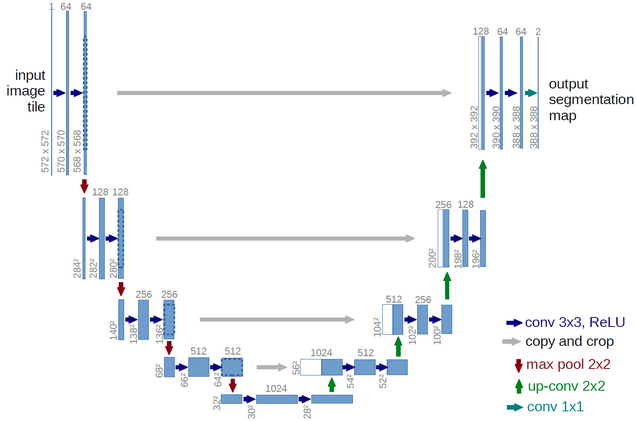)

In [42]:
class Block(nn.Module):
    # a repeating structure composed of two convolutional layers with batch normalization and ReLU activations
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=2, dilation=2), # nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=3, padding=2, dilation=2) with 20 iterations val_acc = 0.9108721079497502
                                   nn.ReLU(),
                                   nn.BatchNorm2d(out_ch),
                                   nn.Conv2d(in_channels=out_ch, out_channels=out_ch, kernel_size=3, padding=1),
                                   nn.ReLU()
                                   )

    def forward(self, x):
        return self.block(x)


class UNet(nn.Module):
    # UNet-like architecture for single class semantic segmentation.
    def __init__(self, chs=(3,64,128,256,512,1024)):
        super().__init__()
        enc_chs = chs  # number of channels in the encoder
        dec_chs = chs[::-1][:-1]  # number of channels in the decoder
        self.enc_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(enc_chs[:-1], enc_chs[1:])])  # encoder blocks
        self.pool = nn.MaxPool2d(2)  # pooling layer (can be reused as it will not be trained)
        self.upconvs = nn.ModuleList([nn.ConvTranspose2d(in_ch, out_ch, 2, 2) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # deconvolution
        self.dec_blocks = nn.ModuleList([Block(in_ch, out_ch) for in_ch, out_ch in zip(dec_chs[:-1], dec_chs[1:])])  # decoder blocks
        self.head = nn.Sequential(nn.Conv2d(dec_chs[-1], 1, 1), nn.Sigmoid()) # 1x1 convolution for producing the output

    def forward(self, x):
        # encode
        enc_features = []
        for block in self.enc_blocks[:-1]:
            x = block(x)  # pass through the block
            enc_features.append(x)  # save features for skip connections
            x = self.pool(x)  # decrease resolution
        x = self.enc_blocks[-1](x)
        # decode
        for block, upconv, feature in zip(self.dec_blocks, self.upconvs, enc_features[::-1]):
            x = upconv(x)  # increase resolution
            x = torch.cat([x, feature], dim=1)  # concatenate skip features
            x = block(x)  # pass through the block
        return self.head(x)  # reduce to 1 channel


def patch_accuracy_fn(y_hat, y):
    # computes accuracy weighted by patches (metric used on Kaggle for evaluation)
    h_patches = y.shape[-2] // PATCH_SIZE
    w_patches = y.shape[-1] // PATCH_SIZE
    patches_hat = y_hat.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    patches = y.reshape(-1, 1, h_patches, PATCH_SIZE, w_patches, PATCH_SIZE).mean((-1, -3)) > CUTOFF
    return (patches == patches_hat).float().mean()

Performing epoch  1/15 


Epoch 1/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 35.116857857539735
  	- val_loss = 0.5016644823140112
  	- acc = 0.8060340018107973
  	- val_acc = 0.8229820748855328
  	- patch_acc = 0.6505517055248392
  	- val_patch_acc = 0.2840827528772683
 


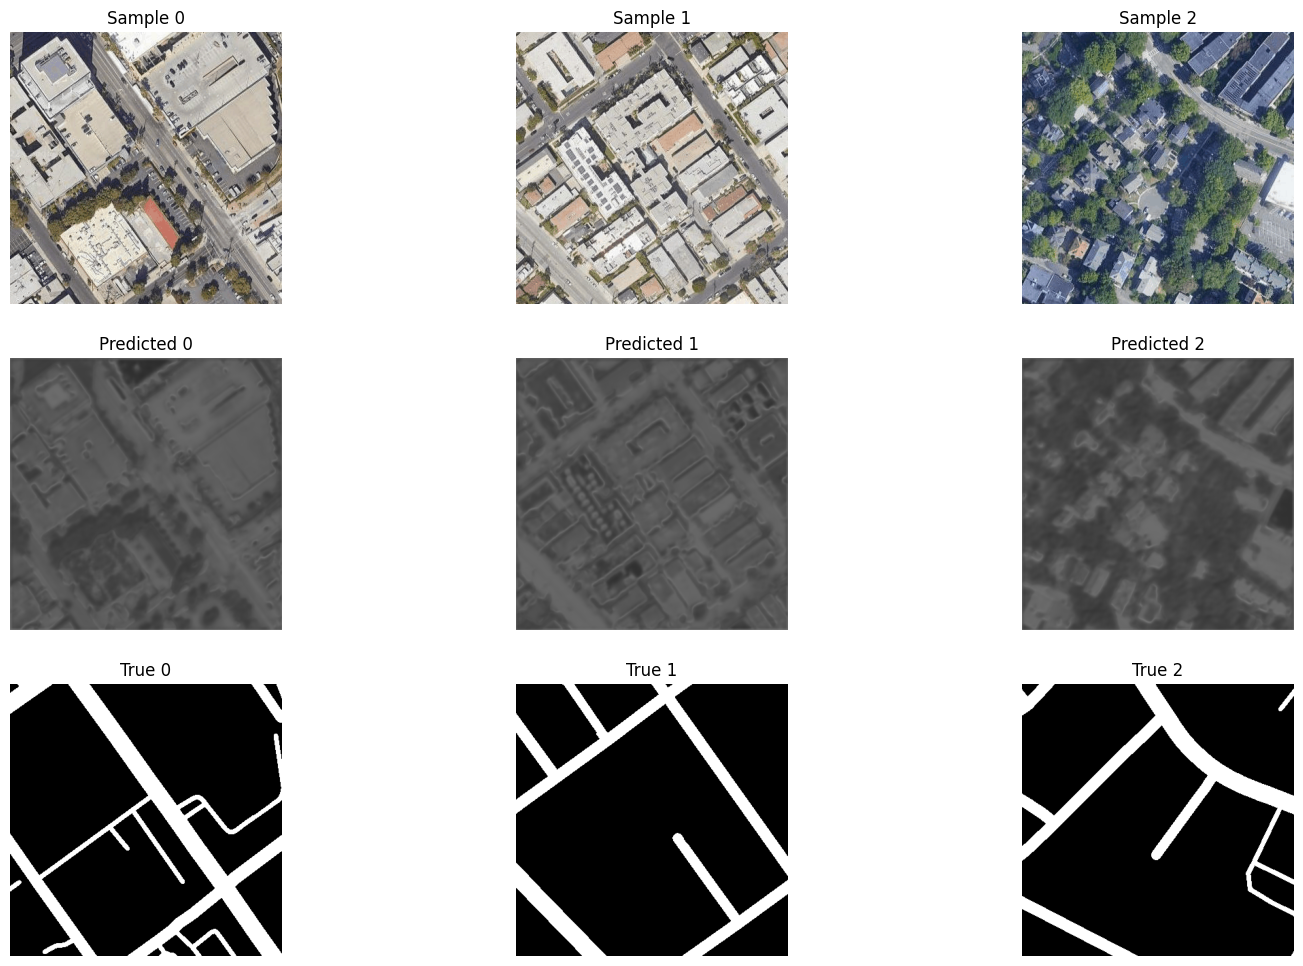

Performing epoch  2/15 


Epoch 2/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 27.928763093619512
  	- val_loss = 0.4274126024081789
  	- acc = 0.8381075571323263
  	- val_acc = 0.8322258776631849
  	- patch_acc = 0.7830850317560393
  	- val_patch_acc = 0.6467172236278139
 
Performing epoch  3/15 


Epoch 3/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 26.05252140965955
  	- val_loss = 0.3914394296448806
  	- acc = 0.832922623075288
  	- val_acc = 0.8344637032212883
  	- patch_acc = 0.7823815921257282
  	- val_patch_acc = 0.7872827361369955
 
Performing epoch  4/15 


Epoch 4/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 24.47301279265305
  	- val_loss = 0.4047535215986186
  	- acc = 0.8380686044692993
  	- val_acc = 0.8244385390446104
  	- patch_acc = 0.7764229733368446
  	- val_patch_acc = 0.7551769963626204
 
Performing epoch  5/15 


Epoch 5/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 22.98636870548643
  	- val_loss = 0.3817115467170189
  	- acc = 0.8358107024225695
  	- val_acc = 0.8229015962830906
  	- patch_acc = 0.7703677950234249
  	- val_patch_acc = 0.784983885699305
 
Performing epoch  6/15 


Epoch 6/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 21.580903086169013
  	- val_loss = 0.3891170723684903
  	- acc = 0.8402356443734005
  	- val_acc = 0.8421498352083666
  	- patch_acc = 0.7866804435335356
  	- val_patch_acc = 0.7246436600027413
 


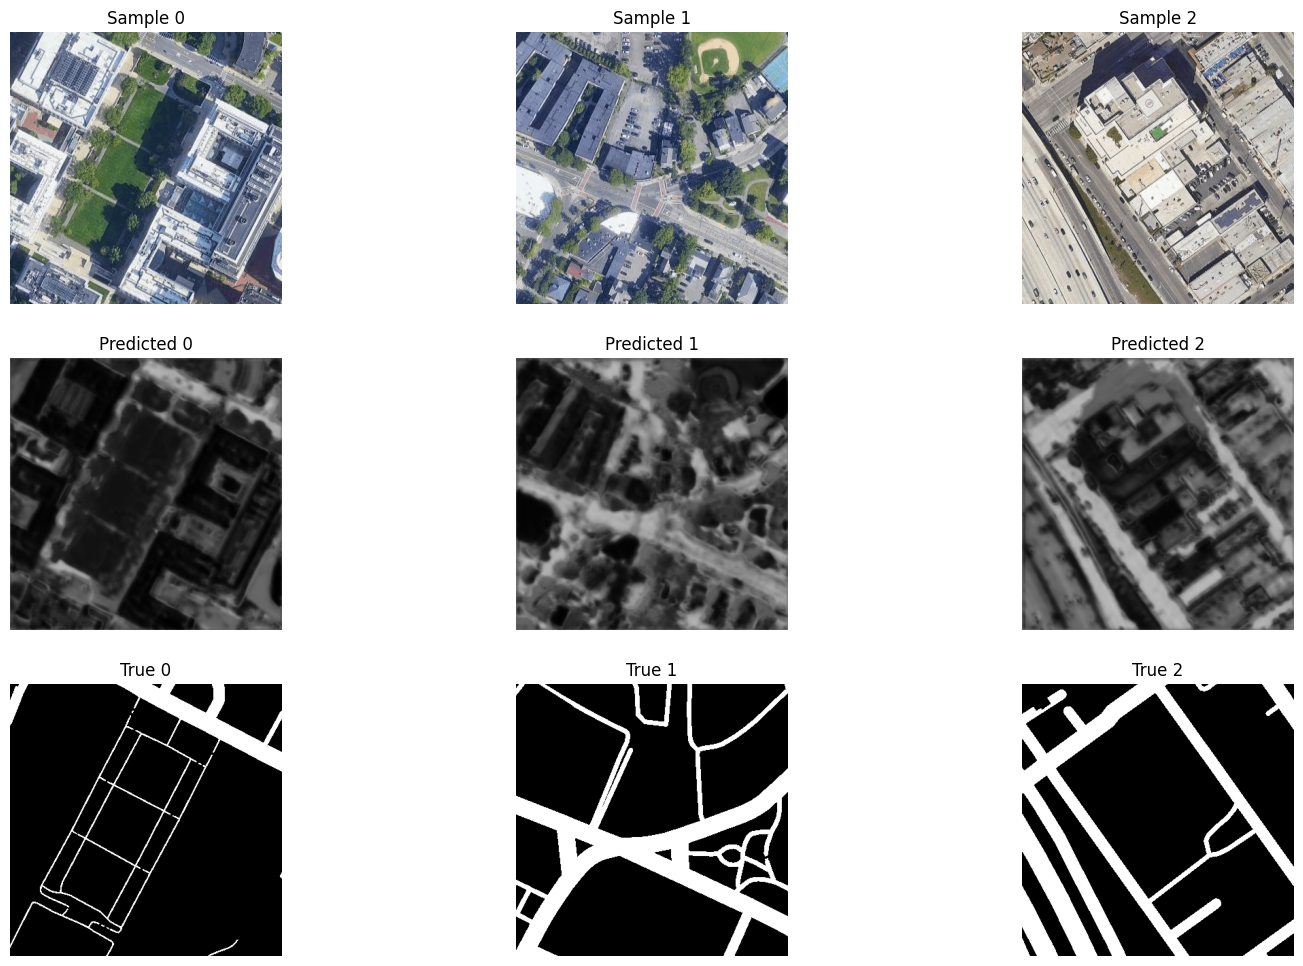

Performing epoch  7/15 


Epoch 7/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 20.24767645474138
  	- val_loss = 0.4566156648356339
  	- acc = 0.8429124334762836
  	- val_acc = 0.8353410568730585
  	- patch_acc = 0.7890574562138525
  	- val_patch_acc = 0.7775126264013094
 
Performing epoch  8/15 


Epoch 8/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 19.00111849554654
  	- val_loss = 0.4120936989784241
  	- acc = 0.8418532671599552
  	- val_acc = 0.8318888298396406
  	- patch_acc = 0.7846344668289711
  	- val_patch_acc = 0.7546206712722778
 
Performing epoch  9/15 


Epoch 9/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 17.801138976524616
  	- val_loss = 0.376975463382129
  	- acc = 0.8372080983786747
  	- val_acc = 0.8431409268543638
  	- patch_acc = 0.7890206698713631
  	- val_patch_acc = 0.8029471039772034
 
Performing epoch  10/15 


Epoch 10/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 16.672702065829572
  	- val_loss = 0.3996725133780775
  	- acc = 0.8443635393833292
  	- val_acc = 0.8394208283259951
  	- patch_acc = 0.7901976848470753
  	- val_patch_acc = 0.7883034327934528
 
Performing epoch  11/15 


Epoch 11/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 15.60139406138453
  	- val_loss = 0.38041191265500823
  	- acc = 0.842620547475486
  	- val_acc = 0.8440496407706162
  	- patch_acc = 0.7882620486719855
  	- val_patch_acc = 0.7700367569923401
 


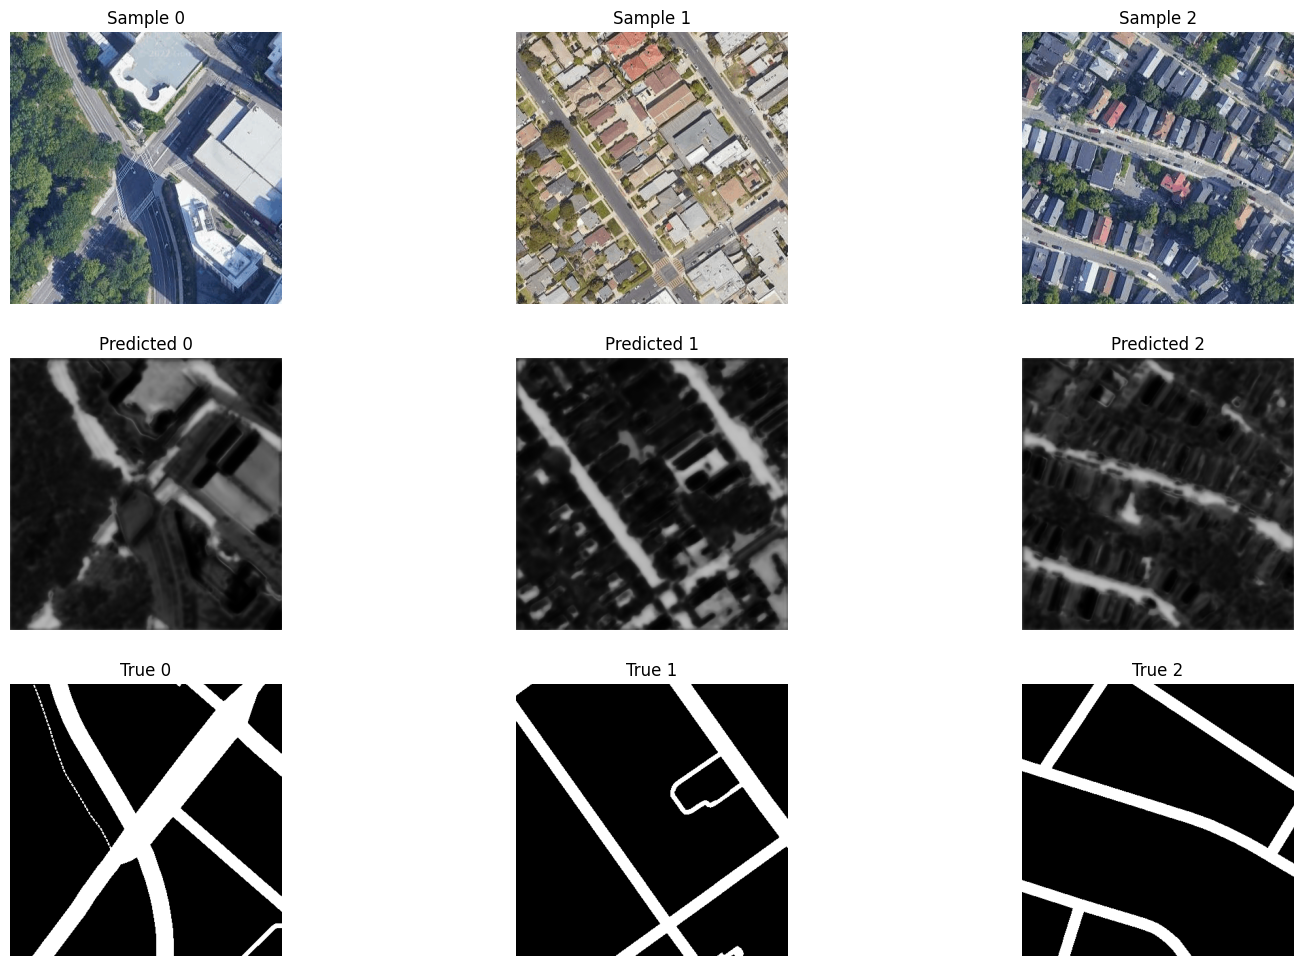

Performing epoch  12/15 


Epoch 12/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 14.582966804504395
  	- val_loss = 0.3611208364881318
  	- acc = 0.8438275353661899
  	- val_acc = 0.8392770249268104
  	- patch_acc = 0.7899126225504381
  	- val_patch_acc = 0.8050298752455876
 
Performing epoch  13/15 


Epoch 13/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 13.619736967415646
  	- val_loss = 0.3970092596678898
  	- acc = 0.8423858469930189
  	- val_acc = 0.8379432826206602
  	- patch_acc = 0.7794206717918659
  	- val_patch_acc = 0.7837471057628763
 
Performing epoch  14/15 


Epoch 14/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 12.699477129969104
  	- val_loss = 0.3769420447020695
  	- acc = 0.8434773560228019
  	- val_acc = 0.8359475526316412
  	- patch_acc = 0.791006877504546
  	- val_patch_acc = 0.779471243249959
 
Performing epoch  15/15 


Epoch 15/15:   0%|          | 0/29 [00:00<?, ?it/s]

	- loss = 11.846616120174014
  	- val_loss = 0.6080236147189962
  	- acc = 0.8385861865405378
  	- val_acc = 0.822583399969956
  	- patch_acc = 0.7825838882347633
  	- val_patch_acc = 0.7545149305771137
 


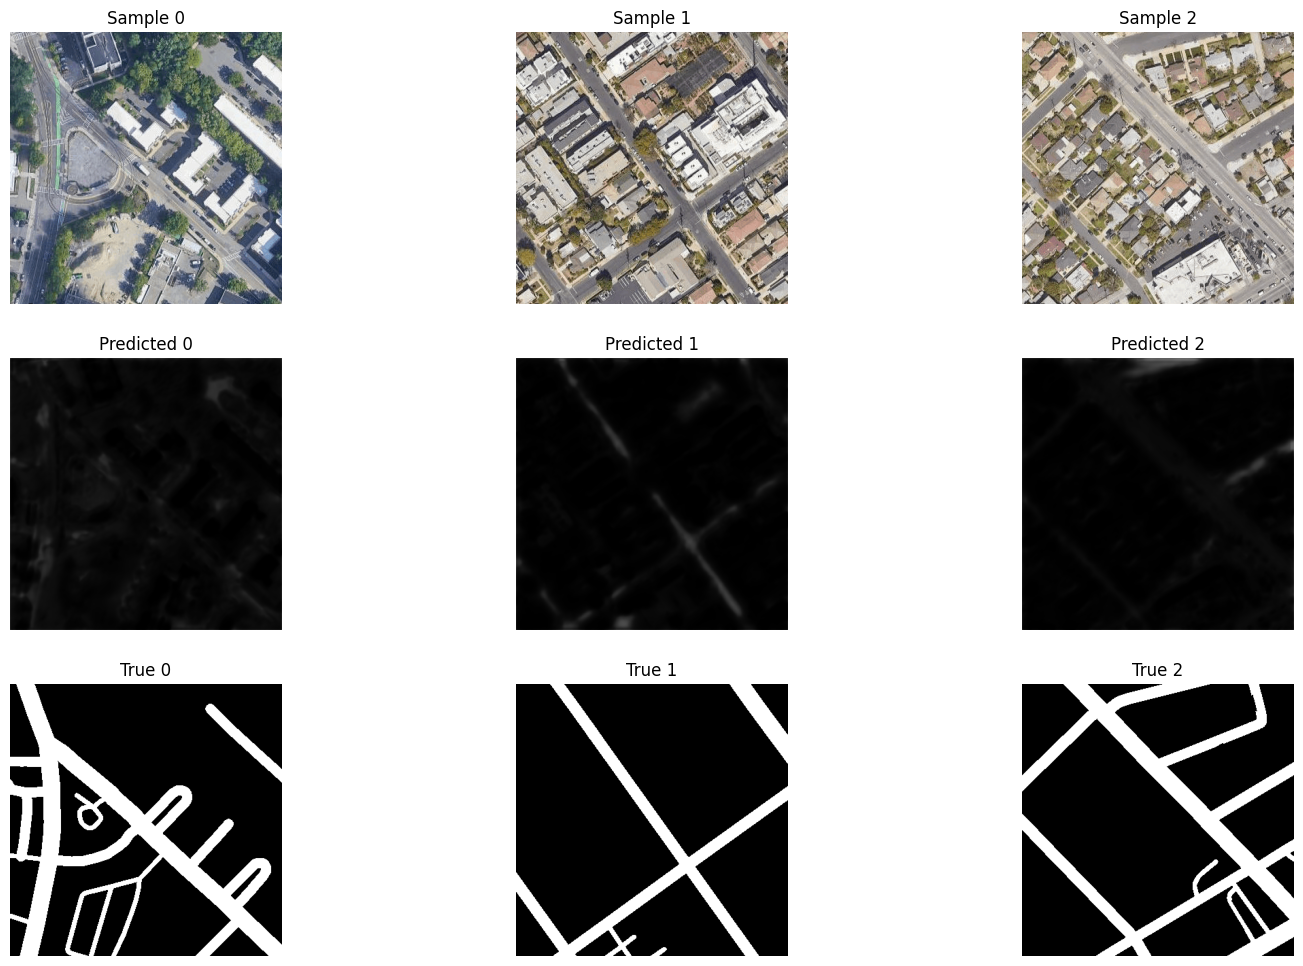

Finished Training


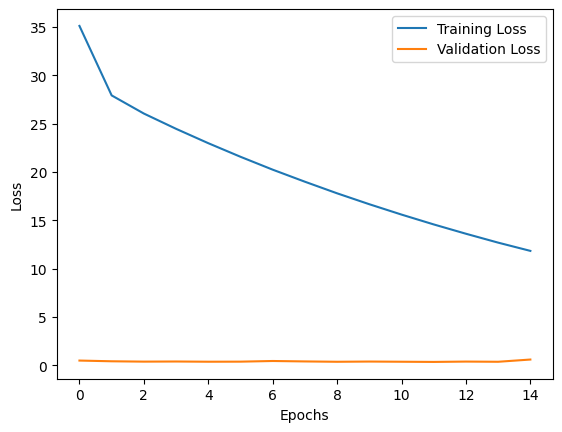

In [43]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# reshape the image to simplify the handling of skip connections and maxpooling
train_dataset = ImageDataset('training', device, use_patches=False, resize_to=(400, 400))
val_dataset = ImageDataset('validation', device, use_patches=False, resize_to=(400, 400))
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=True)
model = UNet().to(device)
loss_fn = nn.BCELoss()
metric_fns = {'acc': accuracy_fn, 'patch_acc': patch_accuracy_fn}
optimizer = torch.optim.Adam(model.parameters())
n_epochs = 15 # default : 5
train(train_dataloader, val_dataloader, model, loss_fn, metric_fns, optimizer, n_epochs)


In [18]:
# predict on test set
test_filenames = (glob(test_path + '/*.png'))
test_images = load_all_from_path(test_path)
batch_size = test_images.shape[0]
size = test_images.shape[1:3]
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
test_images = np.stack([cv2.resize(img, dsize=(384, 384)) for img in test_images], 0)
test_images = test_images[:, :, :, :3]
test_images = np_to_tensor(np.moveaxis(test_images, -1, 1), device)
test_pred = [model(t).detach().cpu().numpy() for t in test_images.unsqueeze(1)]
test_pred = np.concatenate(test_pred, 0)
test_pred= np.moveaxis(test_pred, 1, -1)  # CHW to HWC
test_pred = np.stack([cv2.resize(img, dsize=size) for img in test_pred], 0)  # resize to original shape
# now compute labels
test_pred = test_pred.reshape((-1, size[0] // PATCH_SIZE, PATCH_SIZE, size[0] // PATCH_SIZE, PATCH_SIZE))
test_pred = np.moveaxis(test_pred, 2, 3)
test_pred = np.round(np.mean(test_pred, (-1, -2)) > CUTOFF)
create_submission(test_pred, test_filenames, submission_filename='unet_submission.csv')


In [19]:
from collections import deque

def infer(img, kreis=3):
    point_set = {}
    model_out = model(img).detach().cpu().numpy()
    return model_out
    out_mask = model_out > 0.5 
    
    out_mask = mask_connected_though_border_radius(out_mask)
        
    return out_mask

images_train_for_metric = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'images'))
masks_train_for_metric = load_all_from_path(os.path.join(ROOT_PATH, 'training', 'groundtruth'))

batch_size = images_train_for_metric.shape[0]
size = images_train_for_metric.shape[1:3]
# we also need to resize the test images. This might not be the best ideas depending on their spatial resolution.
images_train_for_metric = np.stack([cv2.resize(img, dsize=(400, 400)) for img in images_train_for_metric], 0)
images_train_for_metric = images_train_for_metric[:, :, :, :3]
images_train_for_metric = np_to_tensor(np.moveaxis(images_train_for_metric, -1, 1), device)

train_pred = [infer(t) for t in tqdm(images_train_for_metric.unsqueeze(1))]
train_pred = np.concatenate(train_pred, 0)[:,0,:,:]

images_train_for_metric= torch.permute(images_train_for_metric,(0,2,3,1))



  0%|          | 0/144 [00:00<?, ?it/s]

Total F1 score without patch postprocessing   : 0.7635431424138164
Total F1 score with patch postprocessing radius 0 : 0.13805817287996722
Total F1 score with patch postprocessing radius 1 : 0.141543742083112
Total F1 score with patch postprocessing radius 2 : 0.7370437781396686
Total F1 score with patch postprocessing radius 3 : 0.7573125825053846
Total F1 score with patch postprocessing radius 4 : 0.7594699993158339
Total F1 score with patch postprocessing radius 5 : 0.7601970175000567
Total F1 score with patch postprocessing radius 6 : 0.7623646209386281
Total F1 score with patch postprocessing radius 7 : 0.7638410446921086
Total F1 score with patch postprocessing radius 8 : 0.7639154606225663
Total F1 score with patch postprocessing radius 9 : 0.7639432815665091


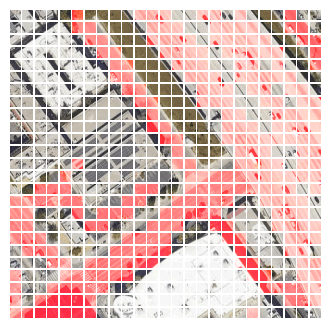

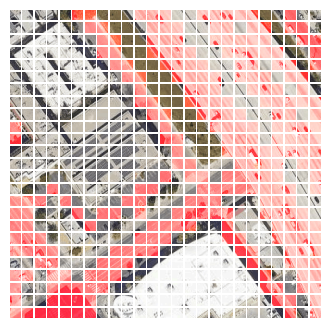

F1 score for frame 0 : 0.839924670433145


In [20]:
def coord_to_array(w, h):
    return w+h*25
    
def mask_connected_though_border_radius(model_out_mask, radius=3):
    mask_connected_though_border_radius_model_out_mask = model_out_mask.copy()
    width, height = 25,25
    assert width==height
    queue_border = deque()
    for wh in range(height): 
        if mask_connected_though_border_radius_model_out_mask[coord_to_array(wh, 0)]==1:
            queue_border.append((wh,0))
            mask_connected_though_border_radius_model_out_mask[coord_to_array(wh, 0)]=2 # 2 = connected to border and discovered 
        elif mask_connected_though_border_radius_model_out_mask[coord_to_array(wh, -1)]==1:
            queue_border.append((wh,-1))
            mask_connected_though_border_radius_model_out_mask[coord_to_array(wh, -1)]=2
        elif mask_connected_though_border_radius_model_out_mask[coord_to_array(0, wh)]==1:
            queue_border.append((0,wh))
            mask_connected_though_border_radius_model_out_mask[coord_to_array(0, wh)]=2
        elif mask_connected_though_border_radius_model_out_mask[coord_to_array(-1, wh)]==1:
            queue_border.append((-1,wh))
            mask_connected_though_border_radius_model_out_mask[coord_to_array(-1, wh)]=2
    while queue_border:
        w, h = queue_border.popleft()
        for i in range(-radius, radius):
            for j in range(-radius, radius):
                if 0 <= w+i < width and 0 <= h+j < height and mask_connected_though_border_radius_model_out_mask[coord_to_array(w+i, h+j)]==1:
                    queue_border.append((w+i,h+j))
                    mask_connected_though_border_radius_model_out_mask[coord_to_array(w+i, h+j)]=2
    return mask_connected_though_border_radius_model_out_mask==2

def patch_postprocessing(patch_postprocessing_label, radius=3):
    patch_postprocessing_label_return = []
    nbr_img = patch_postprocessing_label.size//(25*25)
    for i_img in range(nbr_img):
        patch_postprocessing_label_return = np.append(patch_postprocessing_label_return, mask_connected_though_border_radius(patch_postprocessing_label[i_img*25*25:(i_img+1)*25*25], radius=radius))
    return patch_postprocessing_label_return
    fig, axs = plt.subplots(h_patches, w_patches, figsize=figsize)
    for i, (p, l) in enumerate(zip(patches, labels)):
        # the np.maximum operation paints patches labeled as road red
        axs[i // w_patches, i % w_patches].imshow(np.maximum(p, np.array([l.item(), 0., 0.])))
        axs[i // w_patches, i % w_patches].set_axis_off()
    plt.show()
    
train_patches_for_metric_1, train_labels_for_metric = image_to_patches(images_train_for_metric.detach().cpu().numpy(), train_pred)
train_patches_for_metric_2, train_true_label = image_to_patches(images_train_for_metric.cpu().numpy(), masks_train_for_metric)

print("Total F1 score without patch postprocessing   : %s" % (f1_score(train_labels_for_metric, train_true_label)))


for radius in range(0, 10):
    train_labels_for_metric_post_processing = patch_postprocessing(train_labels_for_metric, radius=radius)
    print("Total F1 score with patch postprocessing radius %s : %s" % (radius, f1_score(train_labels_for_metric_post_processing, train_true_label)))
    
    
for i in range(0,1):
    show_patched_image(train_patches_for_metric_1[i*25*25:(i+1)*25*25], train_labels_for_metric[i*25*25:(i+1)*25*25], figsize=(4, 4))
    show_patched_image(train_patches_for_metric_2[i*25*25:(i+1)*25*25], train_true_label[i*25*25:(i+1)*25*25], figsize=(4, 4))
    print("F1 score for frame %s : %s" % (i, f1_score(train_labels_for_metric[i*25*25:(i+1)*25*25], train_true_label[i*25*25:(i+1)*25*25])))


This final model can get a public score about 0.86 for the public score, which further improves the result of patch CNN.

While it introduces some very important ideas, it is by no means close to state-of-the-art performance, and it can be completely outclassed by more powerful and newer methods. Moreover, many different elements are needed to reach good accuracy, and the right architecture is only one of them. Nevertheless, U-Net represents a good starting point for your project.

# Tips

In conclusion, we will go over some more or less specific tips for your project.

## On Road Segmentation
When you are completely new to a field, an efficient way to get yourself familar to it is to start from reading **overview**. We list several examples below:

* [Deep Learning Approaches Applied to Remote Sensing Datasets for Road Extraction: A State-Of-The-Art Review](https://www.mdpi.com/2072-4292/12/9/1444/htm)
* [Image Segmentation Using Deep Learning: A Survey](https://arxiv.org/pdf/2001.05566.pdf). This is a survey on the more general image segmentation problem

[**Transformer**](https://arxiv.org/pdf/1706.03762.pdf) has recently become a very popular choice in the task of image segmentation and boosted performances in many tasks. Some literatures for general task of image segmentation has been listed here. Notice that since Transformer is intrinsically data hungary, you should consider how to handle this deficiency like considering a pretrained model

* [Rethinking Semantic Segmentation from a Sequence-to-Sequence Perspective with Transformers](https://openaccess.thecvf.com/content/CVPR2021/papers/Zheng_Rethinking_Semantic_Segmentation_From_a_Sequence-to-Sequence_Perspective_With_Transformers_CVPR_2021_paper.pdf)
* [Segmenter: Transformer for Semantic Segmentation](https://arxiv.org/pdf/2105.05633.pdf)
* [SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers](https://proceedings.neurips.cc/paper/2021/file/64f1f27bf1b4ec22924fd0acb550c235-Paper.pdf)

For the concrete task of **road segmentation**, you can refer to following literatures

* [RoadTracer: Automatic Extraction of Road Networks from Aerial Images](https://openaccess.thecvf.com/content_cvpr_2018/papers/Bastani_RoadTracer_Automatic_Extraction_CVPR_2018_paper.pdf)
* [Road Detection and Segmentation from Aerial Images Using a CNN Based System](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8441366)
* [Learning Aerial Image Segmentation from Online Maps](https://arxiv.org/abs/1707.06879)
* [Learning to Label Aerial Images from Noisy Data](https://www.cs.toronto.edu/~vmnih/docs/noisy_maps.pdf)
* [DeepGlobe 2018: A Challenge to Parse the Earth through Satellite Images](https://www.researchgate.net/publication/325215555_DeepGlobe_2018_A_Challenge_to_Parse_the_Earth_through_Satellite_Images)

## On CNNs

Research on CNNs has grown at an intense pace  in recent years. Listing the most influential papers in this context would be a very hard task, so we will just cite a few important works with no claim of completeness. While some of the presented models might not be directly applicable, they introduce interesting ideas.

* [ResNet](https://arxiv.org/abs/1512.03385)
* [Fully Convolutional Networks for Semantic Segmentation](https://arxiv.org/pdf/1411.4038.pdf)
* [DeepLab v1](https://arxiv.org/abs/1606.00915) (v2, v3 and v3+ also exist)
* [PsPNet](https://arxiv.org/abs/1612.01105)

## Concrete Tips
* The point of this project is not about topping the leader board in Kaggle competition, but is to have some novel and interesting ideas on this specific task.

* Besides coming up with interesting ideas, it is also important to present them well, since 70% your score is based on your report. You can use [this](http://www.da.inf.ethz.ch/teaching/2020/CIL/files/cil_sample.zip) as the template.

* Think about how task of road segmentation differs from general segmentation task may help you to generate some ideas.

* Explore the data in depth but **avoid information leakage**.

* Two fundamentals topics were skipped in this notebook, namely pre-processing and post-processing. Both are crucial to this project.

* **Hyperparameter tuning** is a tedious process, but it can have massive impact on your work. For general advices on this topic, you can refer to the book [*deep learning*](https://www.deeplearningbook.org/).

* You do not have to reinvent the wheel and code everything from scratch. Open source implementations of existing models can be a good starting point. On the other hand, coding your own models can be helpful to you as a learner.

* While they might not be interesting for reviewers, methods like ensembling can help you in the competitive part.

* **Be clear about your contribution and choose baselines accordingly.**

# Getting started with the project

### Google Colab:

Colaboratory, or "Colab" for short, allows you to write and execute Python in your browser, with
- Zero configuration required
- Free access to GPUs
- Easy sharing

[Introduction to Colab](https://www.youtube.com/watch?v=inN8seMm7UI) to learn more.

### ETH clusters

ETH provides access to the [Euler](https://scicomp.ethz.ch/wiki/Euler) and [Leonhard](https://scicomp.ethz.ch/wiki/Leonhard) cluster (see also [Getting started with clusters](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys)).

To start:
- Open [VPN](https://www.isg.inf.ethz.ch/Main/ServicesNetworkVPN)!
- [Setup SSH keys](https://scicomp.ethz.ch/wiki/Getting_started_with_clusters#SSH_keys) (only need to do that once).
- Can even run jupyter-notebooks via [this](https://scicomp.ethz.ch/wiki/Jupyter_on_Euler_and_Leonhard_Open). If you want to run with a GPU may need to change the file accordingly (line 64: "python_cpu/3.6.4" -> "python_gpu/x.x.x" see [this](https://scicomp.ethz.ch/wiki/Python_on_Leonhard) for available versions, line 139 to request a GPU change rusage demands). To see tensorboard results you can mount the remote directory
```
sshfs <ethz-username>@<cluster-hostname>:<directory>
```
and run tensorboard locally
```
tensorboard --logdir <directory>
```


Ideas: 

- pre mask using color that can't be road
- using line try to find and refine borders
- using a source and sink graph try to restrain the road to one that end at the border
- 
